In [2]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [3]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.cmb_lensing
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = ['#1A1A1A', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

I've pickled a few fishchips experiment objects (Planck, S3, S4) so you don't have to install orphics. We load it in, and get a dictionary with the three experiments.

In [4]:
import pickle
premades = pickle.load( (open("../data/premades.p", "rb")) )

premades

{'Planck': [<fishchips.experiments.CMB_Primary at 0x7fc7019e9828>,
 'S3': [<fishchips.experiments.CMB_Primary at 0x7fc701ec1828>,
 'S4': [<fishchips.experiments.CMB_Primary at 0x7fc701ec3a90>,
  <fishchips.cmb_lensing.CMB_Lensing_Only at 0x7fc701ec5eb8>]}

Next let's generate an observables object.

In [5]:
# create an Observables object to store information for derivatives
pars = np.array( ['omega_b', 'omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio'])
centers = np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06])
steps = np.array([0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-steps,
                  right=centers+steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   'non linear': 'halofit'}
# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

# generate the fiducial cosmology
obs.compute_cosmo(key='fiducial', classy_dict=classy_template)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_right', classy_dict=classy_right)

In [6]:
fid_cosmo = obs.cosmos['fiducial']
Tcmb = fid_cosmo.T_cmb()
fid_cl = fid_cosmo.lensed_cl(5000)
fid = {'kk': 0.25 * (fid_cl['ell']+2) * (fid_cl['ell']+1)
        *(fid_cl['ell']) * (fid_cl['ell']-1) * fid_cl['pp']}

s3_lensing = premades['S3'][-1]
s4_lensing = premades['S4'][-1]

premades['S3'][-1]

In [8]:
f1 = open('/Users/juliexue/Desktop/fishchips/N_L_xcorr_noise_curve_act_dr6_lensing_map_v1.txt')
actdr6 = []
for x in f1.readlines():
    actdr6.append(x.split()[1])
actdr6_kk_noise = np.array(actdr6[3:2082:])
actdr6_kk_noise = actdr6_kk_noise.astype('float64')

Text(0, 0.5, '$C_{\\ell}^{\\kappa\\kappa}$')

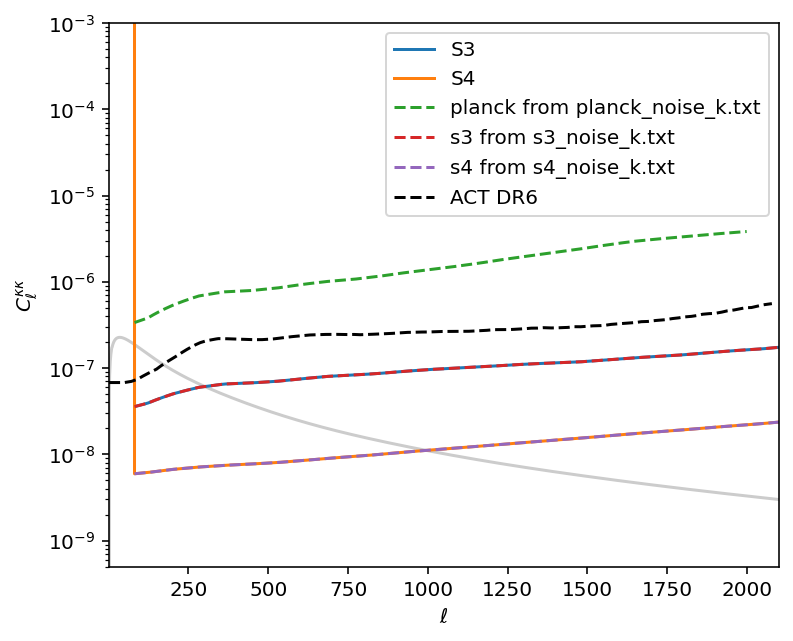

In [12]:
plt.figure(figsize=(6,5))
plt.plot(fid['kk'], color=(0.8,0.8,0.8,1.0))

plt.plot(s3_lensing.noise_k, label="S3")
plt.plot(s4_lensing.noise_k, label="S4")

for exp in ['planck', 's3', 's4']:
    lensing_noise = np.genfromtxt(f'{exp}_noise_k.txt')[:,3]
    lensing_noise[lensing_noise > 1e20] = np.nan
    l_ranges = np.arange(len(lensing_noise))
    pp_to_kk_conv = (l_ranges+1)*(l_ranges) /4
    plt.plot(lensing_noise * pp_to_kk_conv, ls="--", label=f"{exp} from {exp}_noise_k.txt")


plt.ylim(0.5e-9,1e-3)
plt.yscale('log')
# plt.xscale('log')
plt.xlim(2,2100)
plt.plot(actdr6_kk_noise, ls="--", color="black", label="ACT DR6")
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{\kappa\kappa}$')
# plt.savefig('lensing_noise_curves.pdf')
# plt.savefig('lensing_noise_curves.eps')

Let's compute a Fisher matrix using the premade S4!

In [5]:
# # sum together fisher matrices
# fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) 
#                   for exp in premades["S4"]], axis=0 )
# cov = np.linalg.inv(fisher) # invert result to get covariance on parameters
# fishchips.util.plot_triangle(obs, cov, 
#                              labels=[r"$\Omega_b h^2$", r"$\Omega_c h^2$", r"$h$",
#                                     r"$A_s$", r"$n_s$", r"$\tau_{reio}$"]);

The premades pickled dictionary was made with the following code:

In [ ]:
# import pickle

# p = fishchips.experiments.get_PlanckPol_combine()
# s3 = fishchips.experiments.get_S3() + [fishchips.experiments.get_S3_Lensing_Only()]
# s4 = fishchips.experiments.get_S4() + [fishchips.experiments.get_S4_Lensing_Only()]
# print("Planck\n", p)
# print("S3\n", s3)
# print("S4\n", s4)

# import pickle
# pickle.dump({"Planck": p, "S3":s3, "S4":s4},  open( "../data/premades.p", "wb") )